# Probability Data Structures for Membership Estimation - Constructing a simple Bloom Filter
## Author: Denislav Dyakov

## Abstract

In this paper, we explain the basics of Probabilistic Data Structures and Bloom filters in particular. We build a simplistic Bloom filter in Python from scratch, instead of using readily available modules, to get a better understanding of it. In addition we present the results of some performance testing, comparing the search times between out Bloom filter and two deterministic algorithms - linear and binary searches. Our findings suggest that the Bloom filter performed faster than a binary search (sortin the list was not taken into consideration in the measurements). In addition the variability of search times for the Bloom filter is lower than the one of the Binary search. Finaly we discuss both the advantages and disadvantages of Bloom filters.


## Introduction to Data Structures

A data structure is defined as a format for storing, organizing and managing data, for better algorithm efficiency [1].
Data structures (will be refered to as "DSs" from here onward) are not to be confused with Data types. A Data type is defined as "a set of values together with operations" [2], while a DS is the physical implementation of the Data type itself. 
DSs include information about the data, as well as applicable relationships between the data and functions. They are essential for managing large amounts of information efficiently and can be used to translate abstract data types in the application. For example displaying a relational database as a binary tree. 

DSs can be classified in two types, based on the way they are accessed: Linear and Non-linear [3]. 

Some of the commonly used Linear DSs include:
- Arrays - which store a collection of items, each identified by at least one index/key.
- Stacks and Queues - which store a collection of items in the order of opperations applied. Stacks follow the LIFO principle, while Queues follow the FIFO one.
- Linked lists - which store data in linear order and each element points to the next.

And some of the Non-liniar DSs are:
- Trees - which store data in hierarchical ways
- Graphs - a set of nodes and edges

## A review of Probabilitic Data Structures

Probabilistic DSs are described as "data structures based mostly on different hashing techniques" [4]. Generally speaking, Probabilistic DSs use hash functions to randomize and compactly represent a set of items [5]. Unlike the regular DSs, they provide an estimation rather than an exact answer. This lack of precision is compensated by the low memory requirements, fast speeds of execution, as well as potential for scaling. Such properties make Probabilistic DSs ideal for big data, streaming and statistical analysis applications.

There are several types of problems that probabilistic functions aim to solve, namely:

##### Membership - to decide whether an element belongs to a dataset or not. 
Some of these PDSs are: Bloom filter, Counting Bloom filter, Quotient filter and Cuckoo filter.

##### Cardinality - to find the number of distinct elements in a dataset, where duplicates are present. 
Some of these PDSs are: Linear Counting, Probabilistic Counting, LogLog and HyperLogLog.

##### Frequency - to find the frequencies of elements in a dataset. 
Some of these PDSs are: Majority algorithm, Frequent Algorithm, Count Sketch and Count-Min Sketch.

##### Rank - to calculate rank-based characteristics of the data in a dataset such as quantiles and percentiles. 
Some of these PDSs are: Random Sampling, q-digest and t-digest

##### Similarity - to numerically express how similar two objects are. 
Some of these PDSs are:Locality-Sensitive hashing, MinHash and Simhash

For the purposes of this paper, we will only review the Bloom Filter PDS. In the next section we will examine it in more detail.

### What is a Bloom filter?

Bloom filters help us to determine if an element is most likely in a dataset or not. They do this by checking the values of a few bits [4].  An empty Bloom filter is essentially a bit array of $m$ bits, that are initially all set to 0. 
It has two main operations:

#### Adding an element to a set
With the help of $k$ number of hash functions (or one and the same hash function with $k$ number of seeds), $k$ number of hash values of the element are generated. These hash value's keys are then mapped to an empty bit array position, chaning its from 0 to 1.

#### Checking if an element is present in a set
Again with the help of $k$ number of hash functions, $k$ number of hash values of the element are generated. If any of the bits at these positions is 0, then we can conclude that the element is definitely not in the set - false negatives are not possible [6]. If, however, all the bits in these position are 1, then there are two possibilities:
- the element is present in the set
- the bits have been changed from 0 to 1 during the addition of another element

This is why we can only conclude that an element is *most likely* in a dataset and allow for a false positive result.

#### How about removing an element?
Removing an element from a set is not possible in Bloom filters. Chaning a bit from 1 to 0 will remove the element, but could also unintentionally remove another element mapped to this particular bit.

#### Examples of uses of Bloom filters



## The Maths behind a Bloom filter
In order to create a Bloom filter we need to control for the probability for a false positive: $p$. To do that, we need to have a good idea about the size of data set that will be added to the Bloom filter: $n$

The formula for calculating the size of the bit array $m$ is:

$$ m = - \frac{n  \ln {}  p} { (\ln {} 2)^2}  $$


After we determine $m$, we can calculate the number of hashes $k$ to use:

$$ k = - \frac{m}{n}  \ln {} 2 $$

Having a Bloom filter with $m$ bits and $k$ hashes, the probability that a certain bit will be 0 after one insertion is:

$$ (1 - \frac{1}{m})^k $$

After $n$ insertions, the probability will change to

$$ (1 - \frac{1}{m})^{nk} $$

Therefore the probability for a false positive $p$ will become

$$ p = (1- (1 - \frac{1}{m})^{nk})^k $$


### Building the estimators from scratch in Python


Here we will build and test a simplistic implementation of a Bloom filer. Our goal will be to search a predefined list of strings and compare the Bloom filter's performance to the performance of two deterministic search algorithms: linear and binary search. 

This implementation can also be reused with different data sets depending on the purpose and data availability. Some examples would be: if a username is already in use, or if you want to figure out if a given IP is a blacklisted one or not.

We start with importing our python modules

In [1]:
%matplotlib inline

In [2]:
import math 

# for the Conda environment, the mmh3 module had to be installed first. 
# since regular pip commands caused the command prompt to freeze, the following command was used: 
# conda install -c conda-forge mmh3
import mmh3 

from bitarray import bitarray 

# conda install nltk  might need to be ran
import nltk

from time import perf_counter 
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np

Following the formulas above, we define a function for calculating the size of the bit array:

In [3]:
def size_of_bit_array(number_of_elements, false_positive_probability): 
    size = - (number_of_elements * math.log(false_positive_probability))/(math.log(2)**2) 
    return int(size) 

We also need to define the optimum number of hashes:

In [4]:
def number_of_hashes(size_of_bit_array, number_of_elements): 
    number = (size_of_bit_array/number_of_elements) * math.log(2) 
    return int(number) 

Next, we will import the data source that would be added to our Bloom filter. For the purposes of this paper, we will use the NLTK module. It includes a small selection of texts from the Project Gutenberg electronic text archive. It is often used for practical work in Natural Language Processing, since it quickly provides large bodies of linguistic data. In our case NLTK will allow us to build large lists of strings, whose hashes will be added to our Bloom filter.

We start by downloading the Gutenberg package data:

In [5]:
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Denis\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

Checking what we have done

In [6]:
gutenberg_corpus = nltk.corpus.gutenberg.fileids()
gutenberg_corpus

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

The corpus includes a list with file ids of the texts that we will utilise. For the purpose of this exercise we will go on and create a list that contains all strings from the first five texts.

In [7]:
words = nltk.corpus.gutenberg.words(gutenberg_corpus[:5])
print("This provides us with a list, containing " + str(len(words)) + " strings.")

This provides us with a list, containing 1451182 strings.


In [8]:
print(words[:10])

['[', 'Emma', 'by', 'Jane', 'Austen', '1816', ']', 'VOLUME', 'I', 'CHAPTER']


Checking the contetns of our data set, we see that it contains words but also symbols that are a part of the particular text. For the purposes of this paper, this should not be a problem, therefore we will not clear the list any further.

We proceed with adding the words from our data source into a bloom list.

For this purpose, we set a false positive probability of 0.05 and calculate the lenght of the bit array based on the number of elements in our data set.

In [9]:
false_positive_probability = 0.01

number_of_elements = len(set(words))
print("The number of elements are: " + str(number_of_elements))

size = size_of_bit_array(number_of_elements,false_positive_probability)
print("The size of the bit array needs to be: " + str(size))

The number of elements are: 21424
The size of the bit array needs to be: 205350


We go on and calculate the number of hashes that will need to be generated in order to achieve such false positive probability.

In [10]:
hash_count = number_of_hashes(size, number_of_elements) 
print(hash_count)

6


We create the bit array and assign the suggested size, after which we set all bits to 0

In [11]:
bit_array = bitarray(size)
bit_array.setall(0)
# a quick check that the array is created and all is set to 0:
print("The bit array is " + str(len(bit_array)) + " bits long, and all of its bits are set to " + str(sum(bit_array)))

The bit array is 205350 bits long, and all of its bits are set to 0


Next we create the functionality for adding elements to the Bloom filter

In [12]:
list_of_hashes = []
for word in words:
    for seed in range(hash_count):
        hash = mmh3.hash(word, seed) % size
        list_of_hashes.append(hash)
        bit_array[hash] = True     

In [13]:
list_of_hashes[:10]

[194952, 25073, 38359, 9357, 41426, 59154, 162406, 201189, 155598, 134023]

Let us check what happend with our bit array. We will take a look at a part of it

In [14]:
bit_array[100000:101000]

bitarray('000011111110001001000110000000011110111010100110111011000001111010010011100011000101110011000011001100001100010110010000000101111001101011011101001011011100000000101000110011010000010011000110100101100010010000101100100010111110100000011111011111101001001100010100010000010100001101001100000010100001001110011001101010011000000010001101000100000010100000011011000100011010101010001011100110101000000010101000000110010101001101011011000010111011010100000010000001010110011101010100000111000000110100000010001010000000111110100110101001000111111111100101011010011100100100001010100001111100010011000000011100001111000001010010100101000001010100000100100111111000101100001100110101101100000011111000010010110001101010000110100101100100110011000111100111000010000010011010000000001011000011010011000111010000001100101010100001101010100101010000110010100110000110010100101010110100010110000010000110010100000001000101100011100011100100011001111010011101000000111010011100000111010111101001000100

As intended, some of the bits have changed from 0 to 1. All the indexes that are stored in our list_of_hashes list are now changed to 1 in our bit array. Let us check that. We will take all unique indexes in the list and see if it matches the sum of bits in the bit array. The logic here is that the bits should change from 0 to 1 for all unique indexes in the list.

In [15]:
assert len(set(list_of_hashes)) == sum(bit_array), "Should be True"

Now that we know that we have added our elements, let us create a function for searching if an element is a member.

In [16]:
def check_bloom_filter(element):
    for seed in range(hash_count): 
        hash = mmh3.hash(element, seed) % size 
        if bit_array[hash] == False: 
            # if any of bit is False then,its not present 
            # in filter 
            # else there is probability that it exist 
            return False
    return True    

Now let us do some testing. 
We want to see if a list of words not present in our data set will return as positives (false positive)
We also want to check if a list of words that are present will return as not being present (false negatives). 
Accoring to the theory, the former should have a probability of 0.05 (as we have defined earlier). The latter should not be possible and we expect no such results.

In [17]:
second_words = nltk.corpus.gutenberg.words(gutenberg_corpus[5:])

In [18]:
different_words = np.setdiff1d(second_words, words)

In [19]:
len(different_words)

29732

In [20]:
different_words[1000:1010]

array(['BOW', 'BOX', 'BRACE', 'BRACELETS', 'BRACTON', 'BRAHMIN', 'BREACH',
       'BREAKERS', 'BREAKFAST', 'BREAKWATER'], dtype='<U20')

In [21]:
# let's test whether the function will incorrectly return a True value
def test_false_positive(list):
    false = []
    true = []
    for word in list:

        if check_bloom_filter(word) == False:
            false.append("False")
        else:
            true.append("True")

    print("The false positive percentage is " + "{:.2%}".format(len(true) / (len(false) + len(true))))

In [22]:
test_false_positive(different_words)

The false positive percentage is 1.01%


The false positive percentage is very close to the $p = 0.01$ that we have set, therefore we can conclude that the test passes

In [23]:
# let's test whether the function will correctly return a False value
def test_false_negative(list):
    false = []
    true = []
    for word in list:

        if check_bloom_filter(word) == False:
            false.append("False")
        else:
            true.append("True")

    print("The false negative percentage is " + "{:.2%}".format(len(false) / (len(false) + len(true))))

In [24]:
test_false_negative(words)

The false negative percentage is 0.00%


This test passes as well.

### Comparing performance


For the purpose of this exercise, we will compare the performance of the search speed our Bloom filter and two deterministic algorithms - linear and binary search. We will sample a list of words from the data set and feed those to the three algorithms in order to compare performance.

In [25]:
random_words = []
for i in range(300):
    random_word = random.choice(words)
    random_words.append(random_word)

In [26]:
random_words[:10]

['that',
 'the',
 'in',
 'danger',
 'fathers',
 'rejoice',
 'Benwick',
 'and',
 'to',
 'happiness']

Then we will define a function that performs a linear search of a list until it finds a target.

In [27]:
def linear_search(list, target): 

    for element in range(len(list)): 
        if list[element] == target: 
            return True
    return False

Let us perform a quick test, by feeding it a word that is not present in the list and a word that is present in it.

In [28]:
assert linear_search(words, random_words[1]) == True, "Should be True"

In [29]:
assert linear_search(words, different_words[1]) == False, "Should be False"

Nothing is returned, by these assertions, therefore the two tests are passed.

Next, we define a function for binary search:

In [30]:
def binary_search(list, target):
    
    #list = sorted(list)
    start = 0
    end = len(list) - 1
    while start <= end:
        middle = (start + end)// 2
        midpoint = list[middle]
        if midpoint > target:
            end = middle - 1
        elif midpoint < target:
            start = middle + 1
        else:
            return midpoint

Again testing with the same tests:

In [31]:
words_sorted = sorted(words)
assert binary_search(words_sorted, random_words[1]) == random_words[1] , "Should be True"

In [32]:
words_sorted = sorted(words)
assert binary_search(words_sorted, different_words[1]) == None, "Should be False"

We will run each of the three searches for each of the random words in our list. Then we will record in separate list the duration of each search. 

In [33]:
# this one might take a while to complete :(.
linear_performance = []
for i in range(len(random_words)):
    
    t1_start = perf_counter()  

    linear_search(words, random_words[i])

    t1_stop = perf_counter() 
    
    linear_performance.append(t1_stop-t1_start)

In [44]:
bin_performance = []
for i in range(len(random_words)):
    

    t1_start = perf_counter()  

    binary_search(words_sorted, random_words[i])

    t1_stop = perf_counter() 

    bin_performance.append(t1_stop-t1_start)
    #print("Elapsed time:", t1_stop, t1_start)  
    #print("Elapsed time during the whole program in seconds:", t1_stop-t1_start) 

In [45]:
bloom_performance = []
for i in range(len(random_words)):
    
    t1_start = perf_counter()  
    

    check_bloom_filter(random_words[i])

    t1_stop = perf_counter() 
    
    bloom_performance.append(t1_stop-t1_start)

In [46]:
df_linear_performance = pd.DataFrame(linear_performance)
df_bin_performance = pd.DataFrame(bin_performance)
df_bloom_performance = pd.DataFrame(bloom_performance)

Let us see what was the average time it took the three search functions to return a result:

In [47]:
print(df_linear_performance[0].mean())
print(df_bin_performance[0].mean())
print(df_bloom_performance[0].mean())

0.2285106699999998
5.778333333428994e-06
3.3963333332091376e-06


In [48]:
print("The Bloom Filter performed " + str(df_bin_performance[0].mean() / df_bloom_performance[0].mean()) + " times faster on average.")

The Bloom Filter performed 1.7013445873904094 times faster on average.


We can also check variability

In [49]:
print(df_linear_performance[0].std())
print(df_bin_performance[0].std())
print(df_bloom_performance[0].std())

0.5694758354504819
2.5656133371723467e-06
5.316283014863496e-07


In [50]:
print("The Bloom Filter has " + str(df_bin_performance[0].std() / df_bloom_performance[0].std()) + " times less variability.")

The Bloom Filter has 4.825953264713886 times less variability.


We can also see how the data from the 300 runs is spread out. For this purpose, we can use box plots and plot the performance data from the three algorithms.

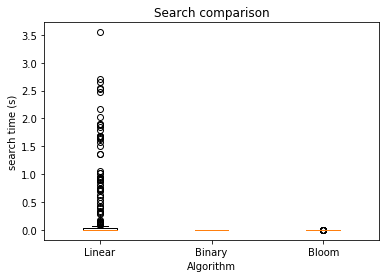

In [51]:
box_plot_data = [linear_performance, bin_performance, bloom_performance]
plt.boxplot(box_plot_data)

plt.xlabel("Algorithm")
plt.ylabel("search time (s)")
plt.xticks([1, 2, 3], ['Linear', 'Binary', 'Bloom'])

plt.title("Search comparison")
plt.show()

The linear search has produced many otliers, so let us exclude it.

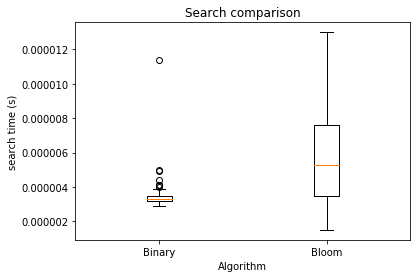

In [52]:
box_plot_data = [bloom_performance, bin_performance]
plt.boxplot(box_plot_data)
plt.xlabel("Algorithm")
plt.ylabel("search time (s)")
plt.xticks([1, 2], ['Binary', 'Bloom'])

plt.title("Search comparison")
plt.show()

We can further limit the y axis to get a better understanding of the results

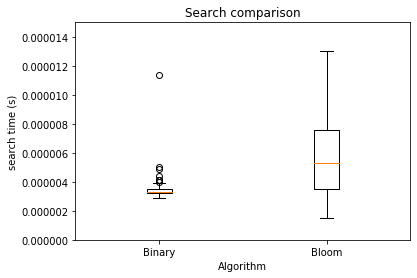

In [55]:
# this limitation might actually be unneccessary, but since each run depends on random inputs, results might vary !
box_plot_data = [bloom_performance, bin_performance]
plt.boxplot(box_plot_data)

plt.xlabel("Algorithm")
plt.ylabel("search time (s)")
plt.xticks([1, 2], ['Binary', 'Bloom'])

plt.title("Search comparison")

plt.ylim(0, 0.000015)
plt.show()

### Concluding remarks

As demonstrated by the test we performed, a bloom filter provides a search speed advantage over the deterministic search algorithms we used. In addition the search times has less variability. Theoretically a Bloom filter also provides better space efficiency, since the data itself is not stored in the bitarray of the Bloom filter. This topic has not been covered in this paper and is a major limitation and an opportunity for further research. 

Still, Bloom filters have their disadvantages as well. To list a few: 
- Bloom filters can only return a result for membership, but cannot return the element itself.
- Removing an element is not an option as discussed earlier in the paper.
- False positives, though contolled, can still be an issue.



### References

[1] https://xlinux.nist.gov/dads/HTML/datastructur.html

[2] https://cs.lmu.edu/~ray/notes/dtds/

[3] https://beginnersbook.com/2018/10/data-structure-introduction/

[4] Gakhov, Andrii. Probabilistic Data Structures and Algorithms for Big Data Applications (p. 8). gakhov. Kindle Edition.

[5] https://dzone.com/articles/introduction-probabilistic-0

[6] https://brilliant.org/wiki/bloom-filter/